In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
import re
import random

In [65]:
df = pd.read_csv('workout_variations.csv')

In [67]:
# Process workout
def parse_workout_column(workout_str):
    return ast.literal_eval(workout_str)

df['Workout'] = df['Workout'].apply(parse_workout_column)

def normalize_exercise_name(name):
    # Convert to lowercase
    name = name.lower()
    # Remove special characters
    name = re.sub(r"[^a-z0-9\s]", "", name)
    name = re.sub(r"[\s]", "_", name)
    return {name}

def normalize_workout_column(workout):
    for day in workout:
        for exercise in day:
            exercise["exercise"] = normalize_exercise_name(exercise["exercise"])
    return workout

# Apply normalization to the 'Workout' column
df["Workout"] = df["Workout"].apply(normalize_workout_column)


In [69]:
def flatten_workout(workout):
    flattened = []
    for day_idx, day_plan in enumerate(workout, 1):
        for exercise in day_plan:
            if exercise:
                exercise['reps'] = int(exercise['reps'])
                if exercise['reps'] <= 8:
                    exercise['reps'] = 8
                elif exercise['reps'] <= 12:
                    exercise['reps'] = 12
                else:
                    exercise['reps'] = 15
                exercise['sets'] = int(exercise['sets'])
                if exercise['sets'] < 3:
                    exercise['sets'] = 3
                elif exercise['sets'] > 5:
                    exercise['sets'] = 5

                if exercise['sets'] != 3 and exercise['sets'] != 4 and exercise['sets'] != 5:
                    exercise['sets'] = 4
                    
                flattened.append(f"Day {day_idx}: {exercise['exercise']} {exercise['sets']}x{exercise['reps']}")
    return " | ".join(flattened)

df['Flattened_Workout'] = df['Workout'].apply(flatten_workout)
df['Flattened_Workout'] = df['Flattened_Workout'].apply(lambda x: f"start {x} end")

df['User_Input'] = df[['Goals', 'Level', 'Days', 'Time', 'Equipments', 'Gender']].apply(
    lambda row: f"{row['Goals']}, {row['Level']}, {row['Days']} days, {row['Time']} minutes, {', '.join(row['Equipments'])}, {row['Gender']}",
    axis=1
)

# Tokenize User Input
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(df['User_Input'])
input_sequences = input_tokenizer.texts_to_sequences(df['User_Input'])
input_vocab_size = len(input_tokenizer.word_index) + 1
max_input_length = max(len(seq) for seq in input_sequences)
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')

# Tokenize Flattened Workout
output_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',)
output_tokenizer.fit_on_texts(df['Flattened_Workout'])
output_sequences = output_tokenizer.texts_to_sequences(df['Flattened_Workout'])
output_vocab_size = len(output_tokenizer.word_index) + 1
max_output_length = max(len(seq) for seq in output_sequences)
padded_output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [71]:
# Define Encoder
encoder_input = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 128)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(128, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_input, encoder_states)

# Define Decoder
decoder_input = Input(shape=(max_output_length,))
decoder_embedding = Embedding(output_vocab_size, 128)(decoder_input)
decoder_lstm = LSTM(128, return_sequences=True)(decoder_embedding, initial_state=encoder_states)
decoder_output = Dense(output_vocab_size, activation='softmax')(decoder_lstm)
decoder_model = Model([decoder_input] + encoder_states, decoder_output)

# Full Model
decoder_input_full = Input(shape=(max_output_length,))
decoder_output_full = decoder_model([decoder_input_full] + encoder_states)
full_model = Model([encoder_input, decoder_input_full], decoder_output_full)

full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define special tokens
start_token = output_tokenizer.word_index['start']
end_token = output_tokenizer.word_index['end']

# Add start token to decoder input and shift target sequences
decoder_input_sequences = np.insert(padded_output_sequences, 0, start_token, axis=1)[:, :-1]
decoder_target_sequences = np.expand_dims(padded_output_sequences[:, 1:], -1)

# Ensure padding matches the model's expectations
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_output_length, padding='post')
decoder_target_sequences = pad_sequences(decoder_target_sequences, maxlen=max_output_length, padding='post')

assert padded_input_sequences.shape[0] == padded_output_sequences.shape[0], "Input and Output sequences should have the same number of samples."

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    padded_input_sequences, padded_output_sequences, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Also split the target sequences
X_train_decoder, X_val_decoder, y_train_decoder, y_val_decoder = train_test_split(
    decoder_input_sequences, decoder_target_sequences, test_size=0.2, random_state=42
)

# Double-check the shapes of the decoder input and target sequences
print("X_train_decoder shape:", X_train_decoder.shape)
print("y_train_decoder shape:", y_train_decoder.shape)
print("X_val_decoder shape:", X_val_decoder.shape)
print("y_val_decoder shape:", y_val_decoder.shape)

X_train shape: (6112, 107)
y_train shape: (6112, 574)
X_val shape: (1528, 107)
y_val shape: (1528, 574)
X_train_decoder shape: (6112, 574)
y_train_decoder shape: (6112, 574, 1)
X_val_decoder shape: (1528, 574)
y_val_decoder shape: (1528, 574, 1)


In [73]:
history = full_model.fit(
    [X_train, X_train_decoder],  # Use the decoder input as part of the training data
    y_train_decoder,             # Use the target sequences as the output
    epochs=50,
    batch_size=32,
    validation_data=([X_val, X_val_decoder], y_val_decoder)  # Provide validation data
)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 179s 923ms/step - accuracy: 0.8320 - loss: 2.5811 - val_accuracy: 0.8850 - val_loss: 0.5441
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 176s 924ms/step - accuracy: 0.8980 - loss: 0.4955 - val_accuracy: 0.9216 - val_loss: 0.4168
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 175s 918ms/step - accuracy: 0.9256 - loss: 0.3925 - val_accuracy: 0.9272 - val_loss: 0.3802
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 175s 917ms/step - accuracy: 0.9303 - loss: 0.3699 - val_accuracy: 0.9358 - val_loss: 0.3515
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 175s 918ms/step - accuracy: 0.9388 - loss: 0.3370 - val_accuracy: 0.9396 - val_loss: 0.3280
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 176s 920ms/step - accuracy: 0.9404 - loss: 0.3228 - val_accuracy: 0.9432 - val_loss: 0.3088
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 175s 918ms/step - accuracy: 0.9437 - loss: 0.3020 - val_accuracy: 0.9455 - val_loss: 0.2911
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 177s 925ms/step - accuracy: 0.9465 -

In [74]:
full_model.save('model_10.keras')

In [75]:
full_model.save_weights('weights_10.weights.h5')

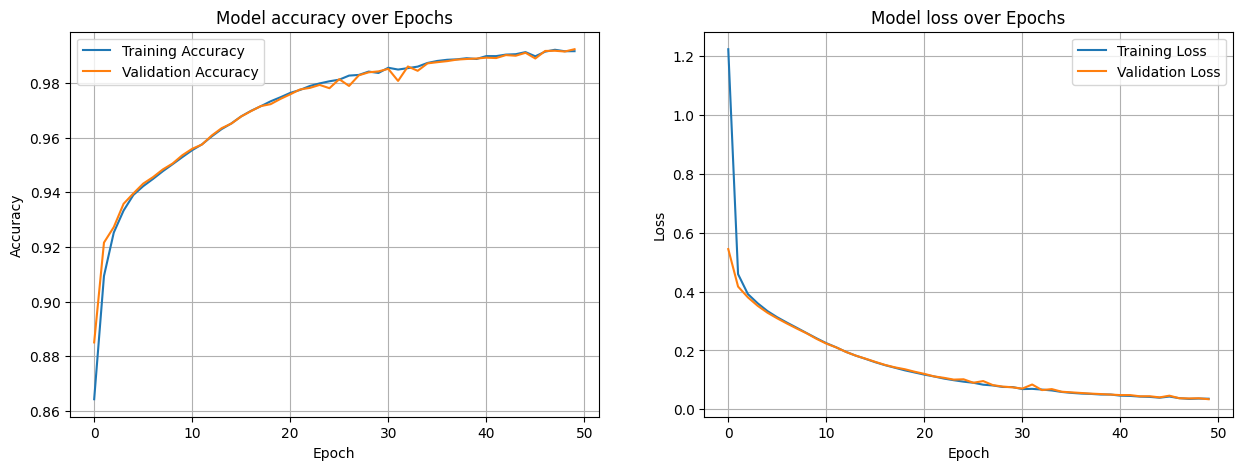

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
plt.show()

In [81]:
model = full_model

In [41]:
model = keras.models.load_model('model_6.keras')

KeyboardInterrupt: 

In [15]:
full_model.load_weights('weights_8.weights.h5')
model = full_model

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [83]:
def sample_decode(input_sequence, model, max_output_length, start_token, end_token, temperature=1.0):
    decoder_input = np.array([[start_token]])  # shape (1, 1)
    generated_sequence = []
    
    encoder_input = np.array([input_sequence])  # shape (1, input_sequence_length)
    
    for _ in range(max_output_length):
        # Predict the next token in the sequence with temperature
        decoder_output = model.predict([encoder_input, decoder_input])[0, -1, :]
        
        # Apply temperature sampling
        probs = np.exp(decoder_output / temperature) / np.sum(np.exp(decoder_output / temperature))
        
        # Sample from the distribution
        predicted_token = np.random.choice(len(probs), p=probs)  # Sample from the distribution
        
        # If the predicted token is the end token, stop generating
        if predicted_token == end_token:
            break
        
        generated_sequence.append(predicted_token)
        decoder_input = np.array([[predicted_token]])  # shape (1, 1)

    return generated_sequence


In [85]:
def format_workout(sequence):
    decoded_sequence = [output_tokenizer.index_word.get(token, '') for token in sequence]
    decoded_sequence = [word for word in decoded_sequence if word not in ['start', 'end']]

    formatted_workout = ""
    day_count = 1
    for word in decoded_sequence:
        if word.startswith("Day"):
            formatted_workout += f"\n\nDay {day_count}:\n"
            day_count += 1
        else:
            formatted_workout += f"{word} "

    return formatted_workout.strip()


In [110]:
def generate_workout(user_input, input_tokenizer, output_tokenizer, max_input_length=107, max_output_length=50, temperature=1.0):
     # Tokenize User Input
    input_sequences = input_tokenizer.texts_to_sequences([user_input])
    input_vocab_size = len(input_tokenizer.word_index) + 1

    # Pad the input sequence to match the expected max input length used during training
    padded_input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')

    # Define the special tokens for the output sequence
    start_token = output_tokenizer.word_index['start']
    end_token = output_tokenizer.word_index['end']

    # Generate the workout using temperature sampling
    generated_sequence = sample_decode(padded_input_sequences[0], model, max_output_length, start_token, end_token, temperature)

    # Convert generated sequence of tokens back to words
    generated_words = [output_tokenizer.index_word[token] for token in generated_sequence]

    # Join the words into a workout description
    generated_workout = ' '.join(generated_words)
    
    return generated_workout

# Example usage
user_input = "Build Muscle, Beginner, 5, 45, dumbbells, bodyweight, Male"
# Generate workout using the function
generated_workout = generate_workout(user_input, input_tokenizer, output_tokenizer)

def create_workout_template_with_variations(generated_output, days=5):
    exercises = generated_output[1:-1].split("' '")
    
    # Distribute exercises into days
    day_workouts = {f"Day {i+1}": [] for i in range(days)}
    for idx, exercise in enumerate(exercises):
        day = f"Day {(idx % days) + 1}"  # Cycle through days

        if re.findall(r"\d", exercise) == [] and re.findall(r"day", exercise) == []:
            day_workouts[day].append(exercise)
            
        
    
    # Format the workout template with random sets and reps
    template = []
    for day, workout in day_workouts.items():
        if workout:  # Skip empty days
            template.append(f"{day}:")
            for exercise in workout:
                # Generate varying sets and reps
                sets = random.randint(2, 5)  # Randomize sets between 2 to 5
                reps = random.choice([8, 10, 12, 15])  # Randomize reps
                template.append(f"  - {exercise.replace('_', ' ').title()} (Sets: {sets}, Reps: {reps})")
            template.append("")  # Add a blank line after each day
    
    return "\n".join(template)

templated = create_workout_template_with_variations(generated_workout)

print("Generated Workout:", templated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [61]:
print(df['Flattened_Workout'].head())
print(output_tokenizer.word_index)

0    start Day 1: {'wide_push_up'} 4x15 | Day 1: {'...
1    start Day 1: {'diamond_push_up'} 4x15 | Day 1:...
2    start Day 1: {'diamond_push_up'} 4x15 | Day 1:...
3    start Day 1: {'wide_push_up'} 4x15 | Day 1: {'...
4    start Day 1: {'diamond_push_up'} 4x15 | Day 1:...
Name: Flattened_Workout, dtype: object
{'day': 1, '1': 2, '3x12': 3, '3x15': 4, '2': 5, '3': 6, '3x8': 7, '4': 8, '5x8': 9, '4x12': 10, '4x15': 11, '5': 12, 'start': 13, 'end': 14, '5x15': 15, '4x8': 16, '5x12': 17, '6': 18, '7': 19, '8': 20, '9': 21, '10': 22, "'seated_calf_raise'": 23, "'plank'": 24, "'bench_press'": 25, "'standing_calf_raise'": 26, "'deadlift'": 27, "'dumbbell_bench_press'": 28, "'squat'": 29, '12': 30, "'hack_squat'": 31, '11': 32, "'leg_curl'": 33, "'leg_extension'": 34, "'squats'": 35, "'lat_pull_down'": 36, "'lateral_raise'": 37, "'smith_machine_squat'": 38, "'close_grip_bench_press'": 39, "'barbell_curl'": 40, "'one_arm_dumbbell_row'": 41, "'incline_dumbbell_bench_press'": 42, "'incline_benc